In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_vqh3bsg6.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)


In [2]:
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[50,50,50], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 

Active grids: ['regular']


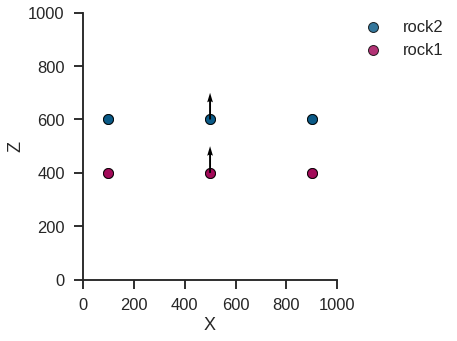

In [3]:
gp.plot.plot_data(geo_data)

In [4]:
dz = geo_data.grid.regular_grid.dz
dz

20.0

In [5]:
geo_data.surfaces.add_surfaces_values([0, 5, 0])

,surface,series,order_surfaces,isBasement,color,id,value_0
0,rock2,Default series,1,False,#015482,1,0
1,rock1,Default series,2,False,#9f0052,2,5
2,basement,Basement,1,True,#ffbe00,3,0


In [6]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_run', gradient=True)

Compiling theano function...
Compilation Done!


In [7]:
gp.compute_model(geo_data, compute_mesh=False)



Lithology ids 
  [3.004875 3.004625 3.004375 ... 0.995625 0.995375 0.995125] 

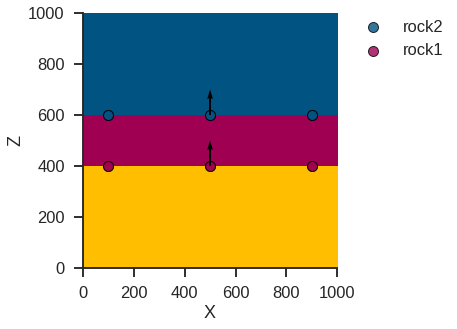

In [8]:
gp.compute_model(geo_data)
gp.plot.plot_section(geo_data, 1, show_data=True)

## Compiling gempy with PyMC3

In [9]:
import theano
import theano.tensor as T
theano.config.compute_test_value = 'ignore'

In [10]:
i = geo_data.interpolator.get_python_input_block()

In [11]:
geo_model_T = theano.OpFromGraph(geo_data.interpolator.theano_graph.input_parameters_loop,
                               geo_data.interpolator.theano_graph.compute_series(), inline=False,
                                 on_unused_input='ignore',
                               name='geo_model')

In [12]:
respect = geo_data.interpolator.theano_graph.input_parameters_loop[4]
m = geo_data.interpolator.theano_graph.compute_series()[0][1][0:125000]
w = m.reshape(geo_data.grid.regular_grid.resolution)[10,1,:]

In [13]:
th_f = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         w,  on_unused_input='ignore')

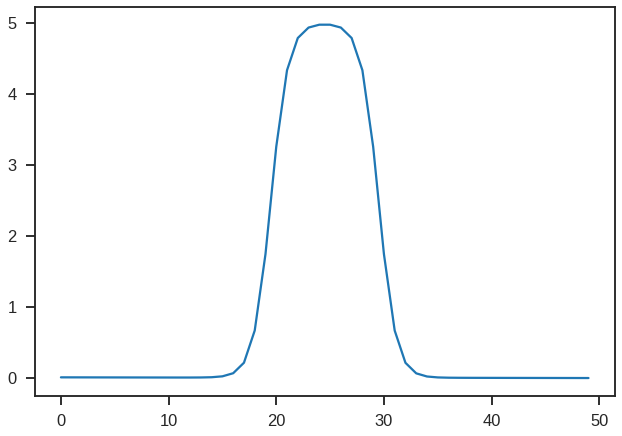

In [14]:
gempy = th_f(*geo_data.interpolator.get_python_input_block())
plt.plot(gempy)

In [15]:
gempy.sum()

50.00001

In [16]:
theano.config.compute_test_value = 'ignore'

th_f_g = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.grad(w.sum(), 
                                respect), on_unused_input='ignore')

In [17]:
gempy_g = th_f_g(*geo_data.interpolator.get_python_input_block())
# 107 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
gempy_g

array([[ 1.7143877e-08,  9.0191776e-08,  3.0173190e+02],
       [ 3.1444287e-09,  2.6751799e-08,  1.3401416e+02],
       [-1.6406154e-09,  4.2321977e-09,  6.4832749e+00],
       [ 3.7167380e-09, -5.0913385e-09, -2.2335773e+01],
       [-5.7457261e-10, -4.9269393e-09, -2.7089792e+01],
       [ 8.6453678e-10,  3.1696628e-09,  7.5926375e+00],
       [-1.7084162e-08, -8.9783697e-08, -3.0099814e+02],
       [-3.1394016e-09, -2.6660572e-08, -1.3367838e+02],
       [ 1.6038115e-09, -4.0643124e-09, -6.4156837e+00],
       [-3.7045194e-09,  5.1725801e-09,  2.2237274e+01],
       [ 5.7104843e-10,  4.9070210e-09,  2.6935221e+01],
       [-8.7232499e-10, -3.1470462e-09, -7.6767473e+00]], dtype=float32)

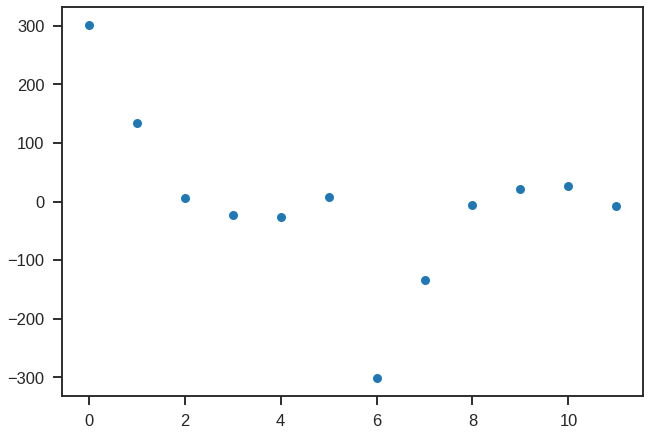

In [19]:
plt.plot(gempy_g[:, 2], 'o')

In [20]:
# geomodel rescaling parameters
rf = geo_data.rescaling.df.loc['values', 'rescaling factor']
centers = geo_data.rescaling.df.loc['values', 'centers']

# df group
g = geo_data.surface_points.df.groupby('id')

In [ ]:
# Converting python numbers to theano shared
input_sh = []
for ii in i:
    input_sh.append(theano.shared(ii))

In [23]:
geo_data.interpolator.theano_graph.input_parameters_loop

[Position of the dips,
 Angle of every dip,
 Azimuth,
 Polarity,
 All the surface_points points at once,
 Full block matrix for faults or drift. We take 2 times len points for the faultdrift.,
 Coordinates of the grid points to interpolate,
 Values that the blocks are taking,
 Vector controlling if weights must be recomputed,
 Vector controlling if scalar matrix must be recomputed,
 Vector controlling if block matrix must be recomputed]

In [28]:

theano.config.compute_test_value = 'ignore'

geo_model_T = theano.OpFromGraph(geo_data.interpolator.theano_graph.input_parameters_loop,
                               [geo_data.interpolator.theano_graph.compute_series()[0][1][0:125000]], inline=True,
                                 on_unused_input='warn',
                               name='geo_model')

In [29]:
geo_data.grid.regular_grid.resolution

array([50, 50, 50])

In [37]:
import theano

import theano.tensor as tt
theano.config.compute_test_value = 'warn'
# We convert a python variable to theano.shared
input_sh = []
for ii in i:
    input_sh.append(theano.shared(ii))

with pm.Model() as model2:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)
    val2 = (r2 - centers[2]) / rf + 0.5001
    val1 = (r1 - centers[2]) / rf + 0.5001

    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[1], 2], val2)
    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[2], 2], val1)
    
    # we have to take the sol 0
    geo = geo_model_T(*input_sh)
    well = geo.reshape((50, 50, 50))[25,25,:]
   # thickness = pm.Deterministic('thickness', well.sum())
   # thickness.name = 'thickness'
    thickness = well.sum()
    a = pm.Normal('y', mu=thickness, sd=20, observed=120)
 #   b = pm.Metropolis()
    trace = pm.sample(1000, chains=1, tune=500,
    #                step =b,
                    compute_convergence_checks=True)
         #   live_plot=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [rock1, rock2]
100%|██████████| 1500/1500 [07:07<00:00,  3.84it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f20f44813c8>,
      dtype=object)

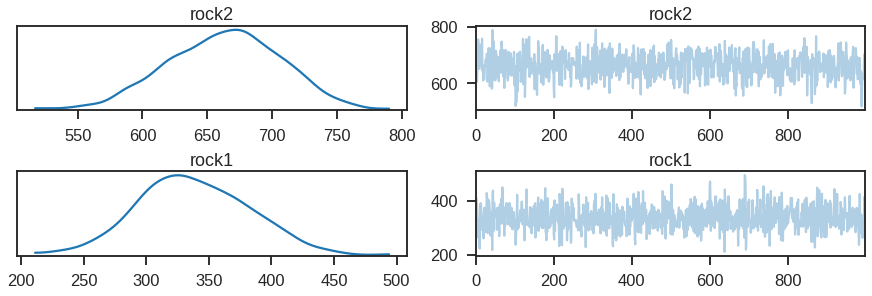

In [38]:
pm.traceplot(trace)

In [43]:
trace.tree_size.sum()

2738.0

In [56]:
trace.get_sampler_stats('mean_tree_accept')

array([0.85027798, 0.71021457, 1.        , 0.7807503 , 1.        ,
       0.64255321, 0.46729177, 0.97132887, 0.17296372, 0.67044697,
       0.44443759, 0.82174468, 1.        , 1.        , 0.83594726,
       0.96580894, 0.30623501, 0.96667701, 0.98801825, 0.97127609,
       0.94356682, 0.86856375, 0.89145815, 0.90321841, 1.        ,
       0.64958143, 0.13121851, 1.        , 0.8991212 , 1.        ,
       0.84694551, 1.        , 0.97966512, 0.82876152, 0.71213639,
       1.        , 0.84058778, 0.99941916, 0.81245777, 1.        ,
       0.68269281, 0.90205271, 0.75213593, 0.95565005, 0.83910741,
       0.91582264, 1.        , 0.97545859, 1.        , 0.48392767,
       0.87090773, 1.        , 1.        , 1.        , 0.73707075,
       0.7165949 , 0.81895039, 0.36427831, 0.97709098, 0.73540304,
       1.        , 0.9653263 , 0.89499093, 0.99402517, 0.59024434,
       0.60320956, 0.91298766, 1.        , 0.606673  , 1.        ,
       1.        , 0.96833668, 0.79910502, 0.81636411, 1.     

In [45]:
(7*60+7)/2738

0.15595325054784515

/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/arviz/data/base.py:123: SyntaxWarning: More chains (1000) than draws (2). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f213bd05390>,
      dtype=object)

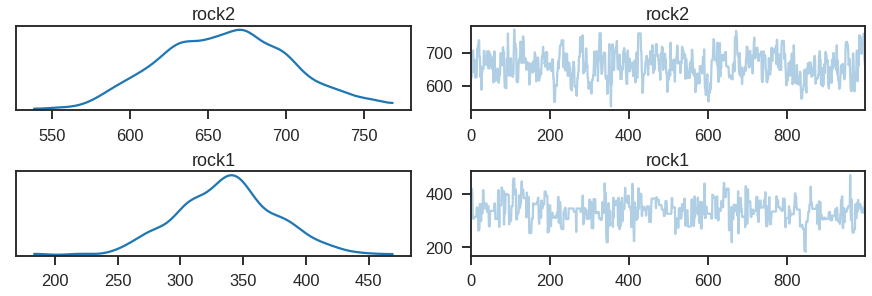

In [32]:
pm.traceplot(trace)

1.62 iterations per second - Macbook

2.51 it/s - Ceres pre-optimization

3,73 it/s - Post-optimization

In [34]:
with model2:
    inference = pm.ADVI()
    approx = pm.fit(n=3000, method=inference)

Average Loss = 16.559: 100%|██████████| 3000/3000 [03:27<00:00, 14.64it/s]
Finished [100%]: Average Loss = 16.554


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f210315e550>,
      dtype=object)

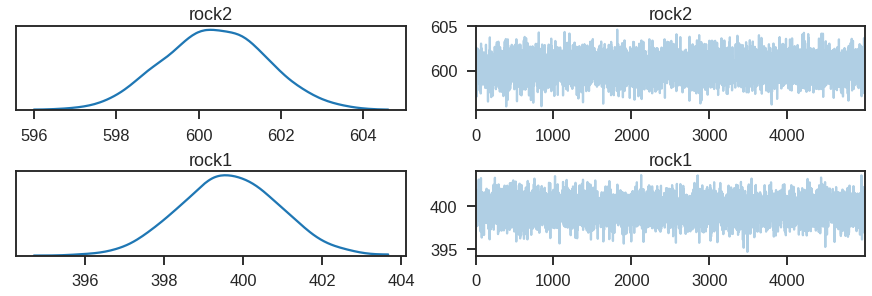

In [36]:
trace = approx.sample(draws=5000)
pm.traceplot(trace)

In [ ]:
model2.logpt

In [ ]:
model2.profile(model2.logpt).summary()

In [ ]:
model2.profile(pm.gradient(model2.logpt, model2.vars)).summary()